In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from collections import Counter
from nltk.probability import FreqDist
import random
import time
random.seed(time.time())
import calendar
import datetime
import statistics

In [2]:
posts_list = pd.read_pickle('./data/investing-posts.pkl')
df_posts = pd.DataFrame(posts_list)
post_manip = df_posts[['title','selftext','created_utc']]    
post_manip['text'] = post_manip['title'] + ' ' + post_manip['selftext']

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [3]:
comments_list = pd.read_pickle('./data/investing-comments.pkl')
df_comments = pd.DataFrame(comments_list)

In [4]:
comment_manip = df_comments[['body','author','created_utc']]    
comment_manip['text'] = comment_manip['body']
comment_manip['word_count'] = comment_manip['text'].apply(lambda x: len(str(x).split(" ")))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [5]:
comment_manip = comment_manip[comment_manip['author'] != 'AutoModerator']
comment_manip = comment_manip[comment_manip['word_count'] < 250]

In [6]:
stop_words = set(stopwords.words('english'))
new_stop_words = set(['removed','x200b', 'amp'])
stop_words = stop_words.union(new_stop_words)
corpus = []
tokenizer = RegexpTokenizer(r'\w+')
for x in post_manip['text']:
    text = str(x.lower())
    text = tokenizer.tokenize(re.sub(r'https?://\S+', '', text))
    ps=PorterStemmer()
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in text if not word in  
            stop_words] 
    text = " ".join(text)
    corpus.append(text)

In [7]:
stop_words = set(stopwords.words('english'))
new_stop_words = set(['removed','x200b', 'amp'])
stop_words = stop_words.union(new_stop_words)
corpus = []
tokenizer = RegexpTokenizer(r'\w+')
for x in comment_manip['text']:
    text = str(x.lower())
    text = tokenizer.tokenize(re.sub(r'https?://\S+', '', text))
    ps=PorterStemmer()
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in text if not word in  
            stop_words] 
    text = " ".join(text)
    corpus.append(text)

In [30]:
from sklearn.feature_extraction.text import CountVectorizer
cv=CountVectorizer(max_df=0.8,stop_words=stop_words, max_features=10000, ngram_range=(1,3))
X=cv.fit_transform(corpus)

In [7]:
#Most frequently occuring words
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in      
                   vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                       reverse=True)
    return words_freq[:n]
#Convert most freq words to dataframe for plotting bar plot
top_words = get_top_n_words(corpus, n=20)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]
#Barplot of most freq words
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
g = sns.barplot(x="Word", y="Freq", data=top_df)
g.set_xticklabels(g.get_xticklabels(), rotation=30)

NameError: name 'corpus' is not defined

               Bi-gram  Freq
0             gt click  3896
1          filing link  3187
2     earnings release  2711
3          click chart  2546
4              2019 07  2409
5            per share  1635
6         stock market  1460
7             chart gt  1355
8             gt stock  1217
9         stock symbol  1157
10          live stock  1143
11          click live  1137
12         stock quote  1137
13            quote gt  1054
14        company last   989
15       since company   988
16       last earnings   988
17   earnings estimate   936
18     market earnings   781
19  consensus estimate   728


[Text(0, 0, 'gt click'),
 Text(0, 0, 'filing link'),
 Text(0, 0, 'earnings release'),
 Text(0, 0, 'click chart'),
 Text(0, 0, '2019 07'),
 Text(0, 0, 'per share'),
 Text(0, 0, 'stock market'),
 Text(0, 0, 'chart gt'),
 Text(0, 0, 'gt stock'),
 Text(0, 0, 'stock symbol'),
 Text(0, 0, 'live stock'),
 Text(0, 0, 'click live'),
 Text(0, 0, 'stock quote'),
 Text(0, 0, 'quote gt'),
 Text(0, 0, 'company last'),
 Text(0, 0, 'since company'),
 Text(0, 0, 'last earnings'),
 Text(0, 0, 'earnings estimate'),
 Text(0, 0, 'market earnings'),
 Text(0, 0, 'consensus estimate')]

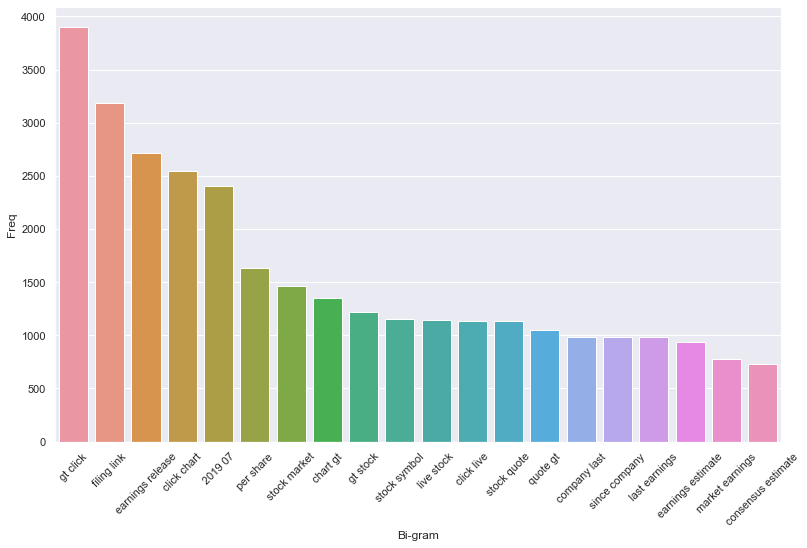

In [32]:
#Most frequently occuring Bi-grams
def get_top_n2_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(2,2),  
            max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]
top2_words = get_top_n2_words(corpus, n=20)
top2_df = pd.DataFrame(top2_words)
top2_df.columns=["Bi-gram", "Freq"]
print(top2_df)
#Barplot of most freq Bi-grams
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot(x="Bi-gram", y="Freq", data=top2_df)
h.set_xticklabels(h.get_xticklabels(), rotation=45)

                    Tri-gram  Freq
0             gt click chart  2094
1             click chart gt  1353
2             chart gt click  1197
3            gt stock symbol  1137
4              gt click live  1137
5           click live stock  1137
6           live stock quote  1137
7             stock quote gt  1054
8         since company last   986
9      company last earnings   986
10     last earnings release   986
11        day moving average   632
12      market earnings time   610
13    earnings time estimate   610
14         per share revenue   595
15            200 day moving   570
16    earnings release stock   540
17  company earnings release   512
18  investor sentiment going   511
19   sentiment going company   511


[Text(0, 0, 'gt click chart'),
 Text(0, 0, 'click chart gt'),
 Text(0, 0, 'chart gt click'),
 Text(0, 0, 'gt stock symbol'),
 Text(0, 0, 'gt click live'),
 Text(0, 0, 'click live stock'),
 Text(0, 0, 'live stock quote'),
 Text(0, 0, 'stock quote gt'),
 Text(0, 0, 'since company last'),
 Text(0, 0, 'company last earnings'),
 Text(0, 0, 'last earnings release'),
 Text(0, 0, 'day moving average'),
 Text(0, 0, 'market earnings time'),
 Text(0, 0, 'earnings time estimate'),
 Text(0, 0, 'per share revenue'),
 Text(0, 0, '200 day moving'),
 Text(0, 0, 'earnings release stock'),
 Text(0, 0, 'company earnings release'),
 Text(0, 0, 'investor sentiment going'),
 Text(0, 0, 'sentiment going company')]

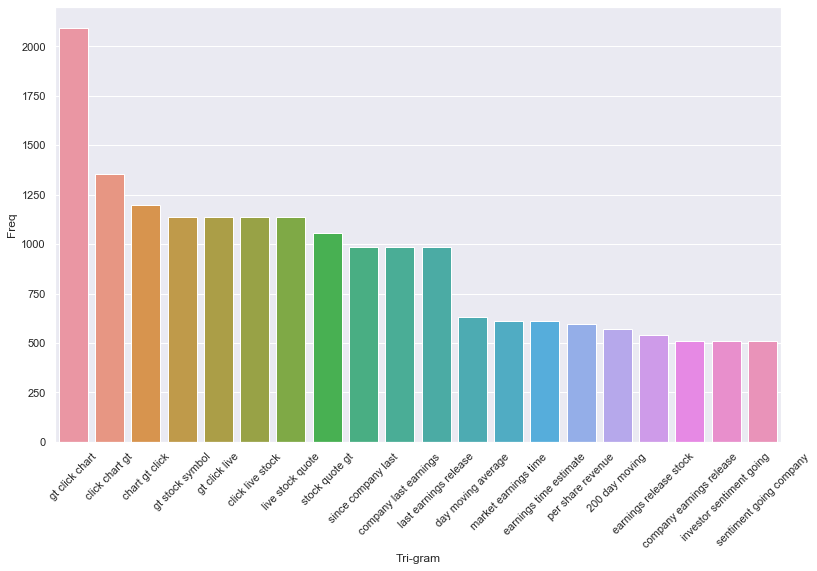

In [33]:
#Most frequently occuring Tri-grams
def get_top_n3_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(3,3), 
           max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]
top3_words = get_top_n3_words(corpus, n=20)
top3_df = pd.DataFrame(top3_words)
top3_df.columns=["Tri-gram", "Freq"]
print(top3_df)
#Barplot of most freq Tri-grams
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
j=sns.barplot(x="Tri-gram", y="Freq", data=top3_df)
j.set_xticklabels(j.get_xticklabels(), rotation=45)

In [34]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(X)
# get feature names
feature_names=cv.get_feature_names()

#Function for sorting tf_idf in descending order
from scipy.sparse import coo_matrix
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
 
def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]
 
    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
 
    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results

def get_keywords(doc):
    #generate tf-idf for the given document
    tf_idf_vector=tfidf_transformer.transform(cv.transform([doc]))

    #sort the tf-idf vectors by descending order of scores
    sorted_items=sort_coo(tf_idf_vector.tocoo())
    #extract only the top n; n here is 10
    keywords=extract_topn_from_vector(feature_names,sorted_items,5)
    return keywords

In [13]:
# fetch document for which keywords needs to be extracted
results = []
target_keywords = ['market', 'call', 'stock market', 'invest']
for text in corpus:
    keywords = get_keywords(text)
    for target in target_keywords:
        if target in keywords:
            results.append((text,keywords))
            break

In [14]:
len(results) / len(corpus)

0.01774490718208997

In [ ]:
stop_words = set(stopwords.words('english'))
tokenizer = RegexpTokenizer(r'\w+')
filtered = tokenizer.tokenize(s)
new_filtered = []
for x in filtered:
    if str(x).lower() not in stop_words:
        new_filtered += [x]

In [ ]:
fdist = FreqDist(new_filtered)
print(fdist.most_common(100))
fdist.plot(30,cumulative=False)
plt.show()

In [ ]:
df_comments['post_id'] = df_comments['link_id'].str.slice(3)

In [ ]:
threads = {}
for index, x in df_posts.iterrows():
    threads[str(x.id)] = str(x.title) + ' ' + str(x.selftext)
for index, x in df_comments.iterrows():
    if str(x.post_id) in threads:
        threads[str(x.post_id)] += ' ' + str(x.body)
threads

In [ ]:
stop_words = set(stopwords.words('english'))
new_stop_words = set(['removed','x200b', 'amp'])
stop_words = stop_words.union(new_stop_words)
corpus = []
tokenizer = RegexpTokenizer(r'\w+')
for x in threads.values():
    text = str(x.lower())
    text = tokenizer.tokenize(re.sub(r'https?://\S+', '', text))
    ps=PorterStemmer()
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in text if not word in  
            stop_words] 
    text = " ".join(text)
    corpus.append(text)    

In [ ]:
y = df_posts[['created_utc','post_id','text','score']]

In [ ]:
l

In [ ]:
df = pd.read_pickle('./result.pkl')

In [ ]:
df.shape

In [ ]:
valid_ids = ['e3zpej', 'e2k4iv', 'e25uok', 'e1efti', 'e0ig5m', 'e0ghtd', 'dypij6', 'dxeu2a', 'dwd2wz', 'dwajrd', 'dvupyr', 'dvd3y0', 'dvcu1p', 'duhvkv', 'duapga', 'du1wal', 'dtwjzd', 'dtv8ci', 'dt1rp0', 'dt07cp', 'dskdlx', 'drqlq5', 'dqlsku', 'dq8sz4', 'dprlgn', 'dpr2rf', 'dpomhj', 'dor1nk', 'domnqg', 'doaoik', 'dmklkt', 'dmiqi4', 'dm575t', 'dlw63u', 'dkxa7k', 'dkox1j', 'divcgw', 'dgxnwq', 'dfzyco', 'dfta3k', 'dff76a', 'dfe0il', 'dfbykd', 'dfat9g', 'df35ww', 'deln1l', 'deitml', 'dehh3v', 'ddizod', 'dce852', 'dbyxna', 'daqlsr', 'dalkw0', 'd9hans', 'd8mswt', 'd87u42', 'd76sxb', 'd6s8n1', 'd5z8wd', 'd58l2m', 'd4mjje', 'd4dnfx', 'd48ekl', 'd3rx1b', 'd3a46h', 'd2gch6', 'd27pkq', 'd20dlt', 'd1yr5g', 'd1nr53', 'd1nm5b', 'd0uawh', 'd0p7d3', 'd0p25w', 'd0bwbi', 'czik4n', 'czgipz', 'czg1g0', 'czdquk', 'cyfyst', 'cxn1cu', 'cxi4uj', 'cx6994', 'cwp2e9', 'cwcxlm', 'cwcj1c', 'cvp99m', 'cvm0a2', 'cu5zwc', 'cu0rvq', 'ctg0sq', 'csi63d', 'cscsma', 'cscilw', 'crltbm', 'cr8jrs', 'cr34l0', 'cqwlu1', 'cqjr3v', 'cq1x20', 'cpvy29', 'cphdud', 'cpe69i', 'cpbr6t', 'cop4vm', 'cof4fp', 'coafqz', 'co6bo5', 'cnvdsd', 'cmxu2k', 'cmrdo7', 'cmlh8o', 'cmkwmk', 'cmivfs', 'cmcq51', 'clu6ty', 'clepqn', 'clczee', 'cl03kd', 'ckj6ql', 'ckg18i', 'ckg12j', 'cju2ve', 'cj8flz', 'cj0rnn', 'cidwkr', 'cfewfi', 'cfeciu', 'cfdy5f', 'cf7lkf', 'cemftk', 'cejzkt', 'cec5wf', 'ce2af5', 'cdokm0', 'cdnwbp', 'cdj6js', 'cdj5es', 'cdj06u', 'ccw1b0', 'ccnb1a', 'cbyp0u', 'cbh34i', 'cb9gwc', 'cb40hr', 'canocv', 'cajw2e', 'cagsym', 'caf2an', 'ca6tft', 'c9wg3k', 'c911ez', 'c8zizc', 'c8u8bo', 'c8tj6i', 'c8e4aq', 'c7rnj3', 'c7ozvl', 'c7k25h', 'c6gzct', 'c6athx', 'c5mykm', 'c5fmi0', 'c4ipvo', 'c4f49v', 'c3egtd', 'c3881o', 'c2ulov', 'c2j1c6', 'c2eknc', 'c26oew', 'c1snig', 'c16ipx', 'c0vtm1', 'c0v9y2', 'c07tnx', 'c0486i', 'bzzfra', 'bzpgrx', 'bzicqe', 'bzhb1s', 'bzd1zu', 'bzbffy', 'bza486', 'bxdy7n', 'bxclyr', 'bx7vds', 'bwkt8n', 'bwic1z', 'bwhqmo', 'bv67ki', 'bugzak', 'bu8sxf', 'btwd20', 'bstd12', 'bsej0b', 'bs0am1', 'brtz9y', 'brtn5j', 'brogjv', 'br9y2c', 'bq35h5', 'bq2nle', 'bpnvif', 'bp9w5y', 'bozcy3', 'bone5v', 'bolbfx', 'bok7bk', 'bmnqkj', 'bmiszy', 'bmfv5b', 'bm7s4v', 'blspov', 'bl7jsf', 'bk6lhb', 'bjtyuf', 'bjogxs', 'bjn5lk', 'bisd0b', 'bisba3', 'bifnq1', 'bhmvx9', 'bhic9o', 'bgatou', 'bg3kgg', 'bfdomd', 'bexwjo', 'bek724', 'bejvtt', 'bdzb9o', 'bdu361', 'bdp60o', 'bdb7sq', 'bbxfku', 'bauugn', 'ba97f0', 'ba1koc', 'b9x32k', 'b97cs6', 'b90gki', 'b8uhy5', 'b8m99v', 'b8i9x7', 'b7gusl', 'b790q8', 'b6moyg', 'b6gisw', 'b6cpe0', 'b6c8l6', 'b6ae7f', 'b5r8um', 'b5jv1m', 'b4yupj', 'b4dzh9', 'b491jm', 'b44k41', 'b3toyb', 'b37ujc', 'b32ba1', 'b2pgns', 'b24dd5', 'b1jotq', 'b16ni8', 'b0txqa', 'b0l4vb', 'b01dh5', 'azzatb', 'azsol0', 'az6w00', 'ayraei', 'aylbpw', 'ay24l3', 'axv9fa', 'axuqkq', 'axkcwi', 'ax6zt4', 'ax6qip', 'awvj3o', 'awex0z', 'avu765', 'av9chp', 'av6yfp', 'auszcs', 'audmvk', 'au4v6m', 'at80i0', 'asrd00', 'arwjkf', 'arr126', 'aqoayn', 'aqaxv5', 'aq4qu0', 'aq15ir', 'apxiq3', 'apijzd', 'ap5av5', 'aoxw4g', 'aotvda', 'aoq0ld', 'ao6trt', 'ao5c3s', 'ao3sb9', 'ao2h19', 'anxxi6', 'anpzjb', 'ang9rt', 'anbgdw', 'an63dn', 'amqvr3', 'amnjrn', 'amg6u1', 'amfwd8', 'alwwny', 'alo1f6', 'almm3q', 'alcnqt', 'akpcn2', 'akjh1e', 'aj8gt8', 'aiytrx', 'aip581', 'aiosdm', 'ailhhg', 'ahvl9w', 'ahsf9q', 'ahj2ip', 'ah3ewm', 'ah2o9p', 'agxs40', 'agwj39', 'agnj3p', 'agc00l', 'ag9880', 'ag5g8o', 'ag581f', 'ag4x7d', 'afvf0r', 'afpl31', 'afg0ym', 'afej5y', 'afc8x5', 'af6xkg', 'aenkuh', 'aemf6o', 'aehz16', 'aebw0v', 'ae790x', 'ae70g4', 'ae4eof', 'adrgya', 'adjget', 'adj7hl', 'adg542', 'add7lu', 'ad9frp', 'acggou', 'ac9vl3', 'ac7582', 'ac3at0', 'abzqr4', 'abvsh9', 'abu25u', 'abt9x5', 'absyoa', 'abk2me', 'ab8y6w', 'ab6lde', 'ab56je', 'ab19qe', 'aax6kp', 'aawxkl', 'aaw674', 'aam1rb', 'aageqb', 'a9vmn4', 'a9up1y', 'a9tnoa', 'a9sfnc', 'a9ok01', 'a9ohwx', 'a98ol9', 'a98kor', 'a8iyq9', 'a8gq29', 'a8gene', 'a8g4di', 'a8e5ad', 'a8d8rx', 'a8bv9l', 'a7yb5n', 'a7xzcg', 'a7xtla', 'a7sre6', 'a7ic2d', 'a7f8wd', 'a7czmt', 'a76kml', 'a75ccy', 'a73yes', 'a6v28k', 'a6b72w', 'a5u30m', 'a5pe34', 'a5hl1y', 'a5dt7a', 'a4wdxx', 'a4q3iy', 'a4kwc6', 'a441jw', 'a3zbij', 'a3pnwv', 'a3pkhs', 'a3pix6', 'a3pilq', 'a3p54y', 'a3o0za', 'a3edhn', 'a3e5w2', 'a33hi0', 'a2xbco', 'a2wr0c', 'a2lhmb', 'a2f24o', 'a2d8wa', 'a23gqr', 'a1yahx', 'a1rzvw', 'a16wcf', 'a13yl0', 'a0tadh', 'a0e9hu', 'a0bedh', '9zsmrz', '9zsj7h', '9za00e', '9z6caf', '9z05ix', '9yy03k', '9ymuqm', '9ymhnk', '9ymepm', '9ygpwa', '9ycqwr']

In [ ]:
len(bruh)

In [ ]:
df_comments['type'] = 'comment'
df_posts['type'] = 'post'
x = df_comments[['created_utc','post_id','text','score','type']]
y = df_posts[['created_utc','post_id','text','score','type']]
all_data = x.append(y,ignore_index=True)
print(all_data.shape)
is_valid = []
count = 0
for x in all_data['post_id']:
    if x in valid_ids:
        is_valid.append(True)
    else:
        is_valid.append(False)
print(count)
all_data = all_data[is_valid]

In [89]:
    df_posts['text'] = df_posts['title'] + ' ' + df_posts['selftext']
    df_posts['used_id'] = df_posts['id']
    print('loaded posts...')

    df_comments['text'] = df_comments['body']
    df_comments = df_comments[df_comments['author'] != 'AutoModerator']
    df_comments['used_id'] = df_comments['link_id'].str.slice(3)
    print('loaded comments...')

loaded posts...
loaded comments...


In [90]:
threads = {}
for index, x in df_posts.iterrows():
    threads[str(x.used_id)] = str(x.title) + ' ' + str(x.selftext)
for index, x in df_comments.iterrows():
    if str(x.used_id) in threads:
        threads[str(x.used_id)] += ' ' + str(x.body)
print('combined into post-comment threads...')

combined into post-comment threads...


In [91]:
stop_words = set(stopwords.words('english'))
new_stop_words = set(['removed','x200b', 'amp'])
stop_words = stop_words.union(new_stop_words)
corpus = []
corpus_w_key = {}
tokenizer = RegexpTokenizer(r'\w+')
for key in threads:
    x = threads[key]
    text = str(x.lower())
    text = tokenizer.tokenize(re.sub(r'https?://\S+', '', text))
    ps=PorterStemmer()
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in text if not word in  
            stop_words] 
    text = " ".join(text)
    corpus.append(text)
    corpus_w_key[key] = text
print('cleaned post-comment threads...')

cleaned post-comment threads...


In [92]:
valid_ids = []
target_keywords = ['market', 'call', 'stock market', 'invest']
for key in corpus_w_key:
    text = corpus_w_key[key]
    keywords = get_keywords(text)
    for target in target_keywords:
        if target in keywords:
            valid_ids.append(key)
            break
print('obtained list of relavent thread-ids...')


obtained list of relavent thread-ids...


In [93]:
# RETURN PICKLE FORMAT OF POSTS / COMMENTS THAT ARE RELAVENT
df_comments['type'] = 'comment'
df_posts['type'] = 'post'
x = df_comments[['created_utc','used_id','text','score','type']]
y = df_posts[['created_utc','used_id','text','score','type']]
all_data = x.append(y,ignore_index=True)
is_valid = []
for x in all_data['used_id']:
    if x in valid_ids:
        is_valid.append(True)
    else:
        is_valid.append(False)
all_data = all_data[is_valid]

In [104]:
len(all_data) / (len(df_comments) + len(df_posts))

0.10588808488369995

In [53]:
df_comments['used_id'].describe()

count     581587
unique     23885
top       dhuq60
freq        2857
Name: used_id, dtype: object

In [88]:
posts_list = pd.read_pickle('./data/investing-posts.pkl')
df_posts = pd.DataFrame(posts_list)
comments_list = pd.read_pickle('./data/investing-comments.pkl')
df_comments = pd.DataFrame(comments_list)

s1 = set(df_posts['id'].tolist())
s2 = set(df_comments['link_id'].str.slice(3).tolist())
s1.intersection(s2)

{'dxlgnr',
 'al6tz1',
 'aad3uo',
 'c3nhvb',
 'a7e9vx',
 'bhvnnt',
 'bwez3k',
 'ana3n1',
 'bzdbjq',
 'aj2fj6',
 'btngq6',
 'bysuhl',
 'bo4z70',
 'a6dg33',
 'cnwgv7',
 'azgqsj',
 'dj74w3',
 'bwlewh',
 'ad3i3a',
 'co1xgg',
 'bu0m31',
 'd9p61k',
 'bg3r5j',
 'ago8c3',
 'ai9i3c',
 'dc0xbq',
 'c3xcwl',
 'dcsmhy',
 'achqzk',
 'ct342a',
 'cbnf28',
 'bc08ed',
 'cp8q2s',
 'a43l4e',
 'd7hleq',
 'c2cb22',
 'a9gd82',
 'cpugx6',
 'c30pgw',
 'b10b25',
 'ajcshk',
 'bau6t2',
 'dz4h5u',
 'codc83',
 'aloq9c',
 'cx37ia',
 'a63xih',
 'dt08vj',
 'd7osll',
 'arfzn1',
 'dj5c5z',
 'at2vwp',
 'bm8lhg',
 'ckz6rf',
 'cfqreb',
 'cntwg0',
 'az7awz',
 'acf0fv',
 'dh3btu',
 'd56awl',
 'dcxf5s',
 'b6azx4',
 'azyhdk',
 'aw6vag',
 'aq84q0',
 'bwy0ng',
 'b9ld0a',
 'dbrtso',
 'amujr9',
 'at1rib',
 'cbfvss',
 'cmcux9',
 'bo9kkh',
 'dm4ulh',
 'cfb23y',
 'c1xika',
 'dz4k9b',
 'c4vje8',
 'a7a8qc',
 'chrwrn',
 'ci6v93',
 'b1f64o',
 'cncokm',
 'd94v0r',
 'bkqu2a',
 'c92ptg',
 'dxx5p3',
 'ct033n',
 'dspwhg',
 'dj1ima',
 'a9ij4z',

In [87]:
df_comments.subreddit

0         investing
1         investing
2         investing
3         investing
4         investing
            ...    
584995    investing
584996    investing
584997    investing
584998    investing
584999    investing
Name: subreddit, Length: 585000, dtype: object

In [3]:
df = pd.read_pickle('./result.pkl')

In [118]:
df.columns

Index(['created_utc', 'used_id', 'text', 'score', 'type', 'sentiment_score'], dtype='object')

In [4]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# nltk.download('vader_lexicon')

# New words and values
new_words = {
    'buy': 5, 
    'crushes': 10,
    'long term': 10,
    'beats': 5,
    'buy calls': 5,
    'short term': 1,
    'misses': -5,
    'sell': -5,
    'buy puts': -5,
    'trouble': -10,
    'falls': -10,
}
# Instantiate the sentiment intensity analyzer with the existing lexicon
vader = SentimentIntensityAnalyzer()
# Update the lexicon
# ... YOUR CODE FOR TASK 4 ...
vader.lexicon.update(new_words)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/salilnadkarni/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [5]:
df['sentiment_score'] = df['text'].apply(lambda x : vader.polarity_scores(x)['compound'])

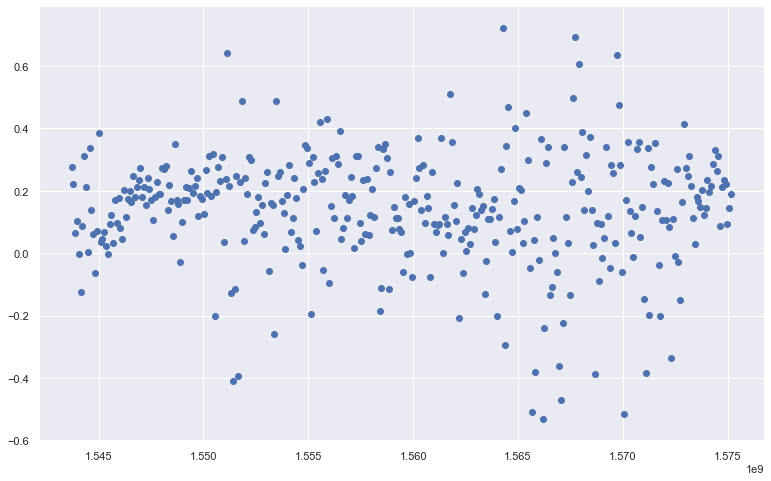

In [51]:
# THIS CODE PLOTS FOR THE WEEK W/ UPVOTES IN MIND
date_sorted_df = df.sort_values('created_utc', ascending=True)
to_plot = []
vals = []
time = calendar.timegm(datetime.datetime(2018, 12, 2).utctimetuple())
step = 500
for index, x in date_sorted_df.iterrows():
    if x.created_utc < time:
        vals += x.score*[x.sentiment_score]
    else:
        to_plot += [(time, statistics.mean(vals))]
        time += 24*60*60
        vals = [x.sentiment_score]
to_plot += [(time, statistics.mean(vals))]
plt.scatter(x=[x[0] for x in to_plot], y=[x[1] for x in to_plot])

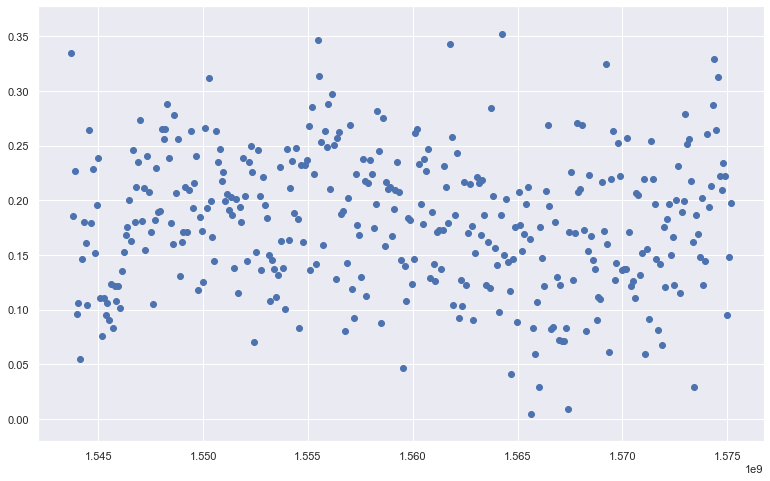

In [53]:
# THIS CODE PLOTS FOR THE WEEK W/ UPVOTES NOT TAKEN INTO ACCOUNT
date_sorted_df = df.sort_values('created_utc', ascending=True)
to_plot = []
vals = []
time = calendar.timegm(datetime.datetime(2018, 12, 2).utctimetuple())
step = 500
for index, x in date_sorted_df.iterrows():
    if x.created_utc < time:
        vals += [x.sentiment_score]
    else:
        to_plot += [(time, statistics.mean(vals))]
        time += 24*60*60
        vals = [x.sentiment_score]
to_plot += [(time, statistics.mean(vals))]
plt.scatter(x=[x[0] for x in to_plot], y=[x[1] for x in to_plot])

count    448.000000
mean       0.212423
std        0.523676
min       -0.992400
25%        0.000000
50%        0.250000
75%        0.678175
max        0.995900
Name: sentiment_score, dtype: float64
count    357.000000
mean       0.143974
std        0.498419
min       -0.966000
25%       -0.153100
50%        0.000000
75%        0.571900
max        0.993800
Name: sentiment_score, dtype: float64


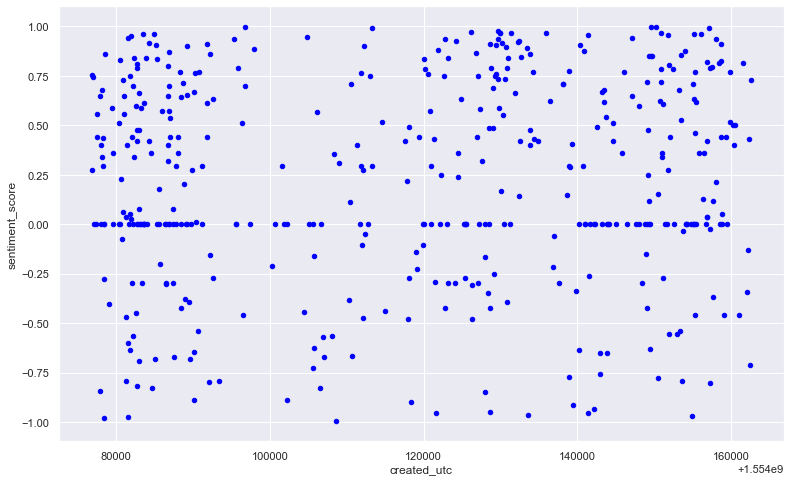

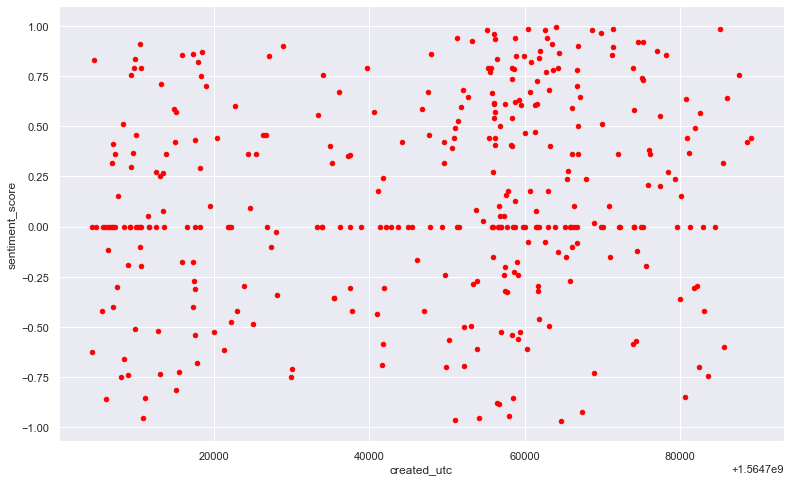

In [9]:
sns.set(rc={'figure.figsize':(13,8)})
df[(df.created_utc > 1554076800) & (df.created_utc < 1554163200)].plot.scatter(x='created_utc', y='sentiment_score', color='blue')
print(df[(df.created_utc > 1554076800) & (df.created_utc < 1554163200)].sentiment_score.describe())
df[(df.created_utc > 1564704000) & (df.created_utc < 1564790400)].plot.scatter(x='created_utc', y='sentiment_score', color='red')
print(df[(df.created_utc > 1564704000) & (df.created_utc < 1564790400)].sentiment_score.describe())

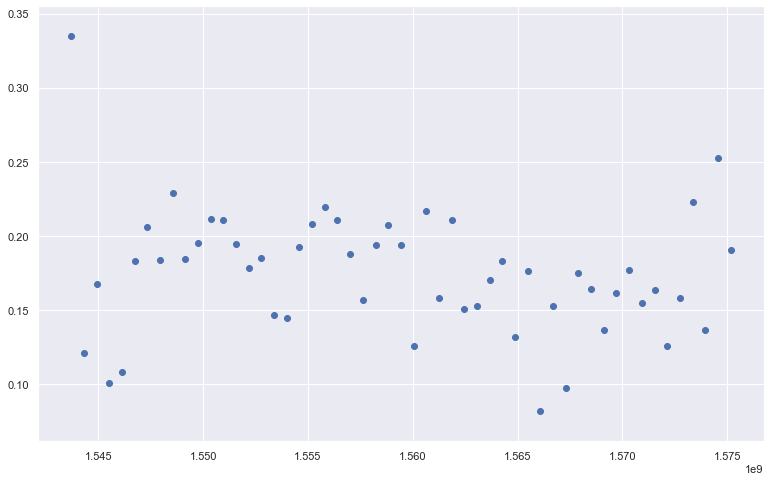

In [52]:
3 * [0]

[0, 0, 0]